In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

In [2]:
OPERATION = 'addition'
assert OPERATION in ['addition', 'multiplication']



In [3]:
# Load model# Set the token as an environment variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'
# full_model_name = 'EleutherAI/pythia-6.9b'
#full_model_name = 'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
remote = False
datapath = f'llm-addition/experimentation'


In [4]:
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
NLAYERS = model.config.num_hidden_layers



Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [5]:
def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'{datapath}/data_{OPERATION}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

def get_nums_hss_solo(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    if MODEL_NAME == 'Llama-3.1-8B':
                        hs = model.model.layers[layer].input
                    elif MODEL_NAME == 'gpt-j-6B':
                        hs = model.transformer.h[layer].inputs[1]['hidden_states']
                    elif MODEL_NAME == 'pythia-6.9b':
                        hs = model.gpt_neox.layers[layer].input
                    activations.append(hs[:,-1].save())
    act = torch.stack(activations).detach().cpu()
    act = act.transpose(0, 1)
    return nums, act


In [97]:
mina = 1
maxa = 99
layer = 3
a, hss = get_nums_hss_solo( mina, maxa)
# Filter out zeros, they cannot be used with log
mask = (a != 0)
hss = hss[mask]
a = a[mask]

In [98]:
#Attempt linear fit vs full hidden state

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy())
# print("coef", model.coef_)
# print("intercept", model.intercept_)
# print("r2 score", model.score(hss[:,layer,:].cpu().float().numpy(), a.cpu().float().numpy()))
# print("predicted", model.predict(hss[:,layer,:].cpu().float().numpy()))
# from sklearn.metrics import r2_score
# y_true = a.cpu().float().numpy()
# y_pred = model.predict(hss[:,layer,:].cpu().float().numpy())
# r2 = r2_score(y_true, y_pred)
# print("R2 score of the model: ", r2)

# Right... this is useless as with 4096 dim hiddeen state, you can regress anything perfectly. Hence PCA. Let's try that...


In [99]:
# PCA decompose and attempt fit against each of them

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

npca = 20


hs = hss[:, layer, :].cpu().float().numpy()
scaler = StandardScaler()
hs_scaled = scaler.fit_transform(hs)

pca = PCA(n_components=npca)
tf = pca.fit_transform(hs_scaled)
# print("explained_variance_ratio", pca.explained_variance_ratio_)
# print("explained_variance", pca.explained_variance_)
# print("singular_values", pca.singular_values_)
# print("components", pca.components_)
for i in range(npca):
    lr = LinearRegression()
    x = np.log(a)[:, None]
    y = tf[:,i]
    lr.fit(x, y)
    # print("coef", i, model.coef_)
    # print("intercept", i, model.intercept_)
    print("r2 score", i, lr.score(x, y))
    # print("predicted", i, model.predict(x))



r2 score 0 0.004086494268946805
r2 score 1 0.7890138579718151
r2 score 2 0.09640228135089624
r2 score 3 0.039073002442307714
r2 score 4 0.0026311154703352324
r2 score 5 0.02213473950753908
r2 score 6 0.007132239983749344
r2 score 7 7.605517027164943e-06
r2 score 8 0.00022179884681383655
r2 score 9 0.010804587022605672
r2 score 10 0.0005643173297698034
r2 score 11 0.00197794053906597
r2 score 12 0.0006583315769209674
r2 score 13 0.0002642898777143188
r2 score 14 0.002324857221461696
r2 score 15 0.0005897664494038946
r2 score 16 0.000272004316643093
r2 score 17 0.0027301660522961457
r2 score 18 0.003934427022085352
r2 score 19 0.0009895641398542931


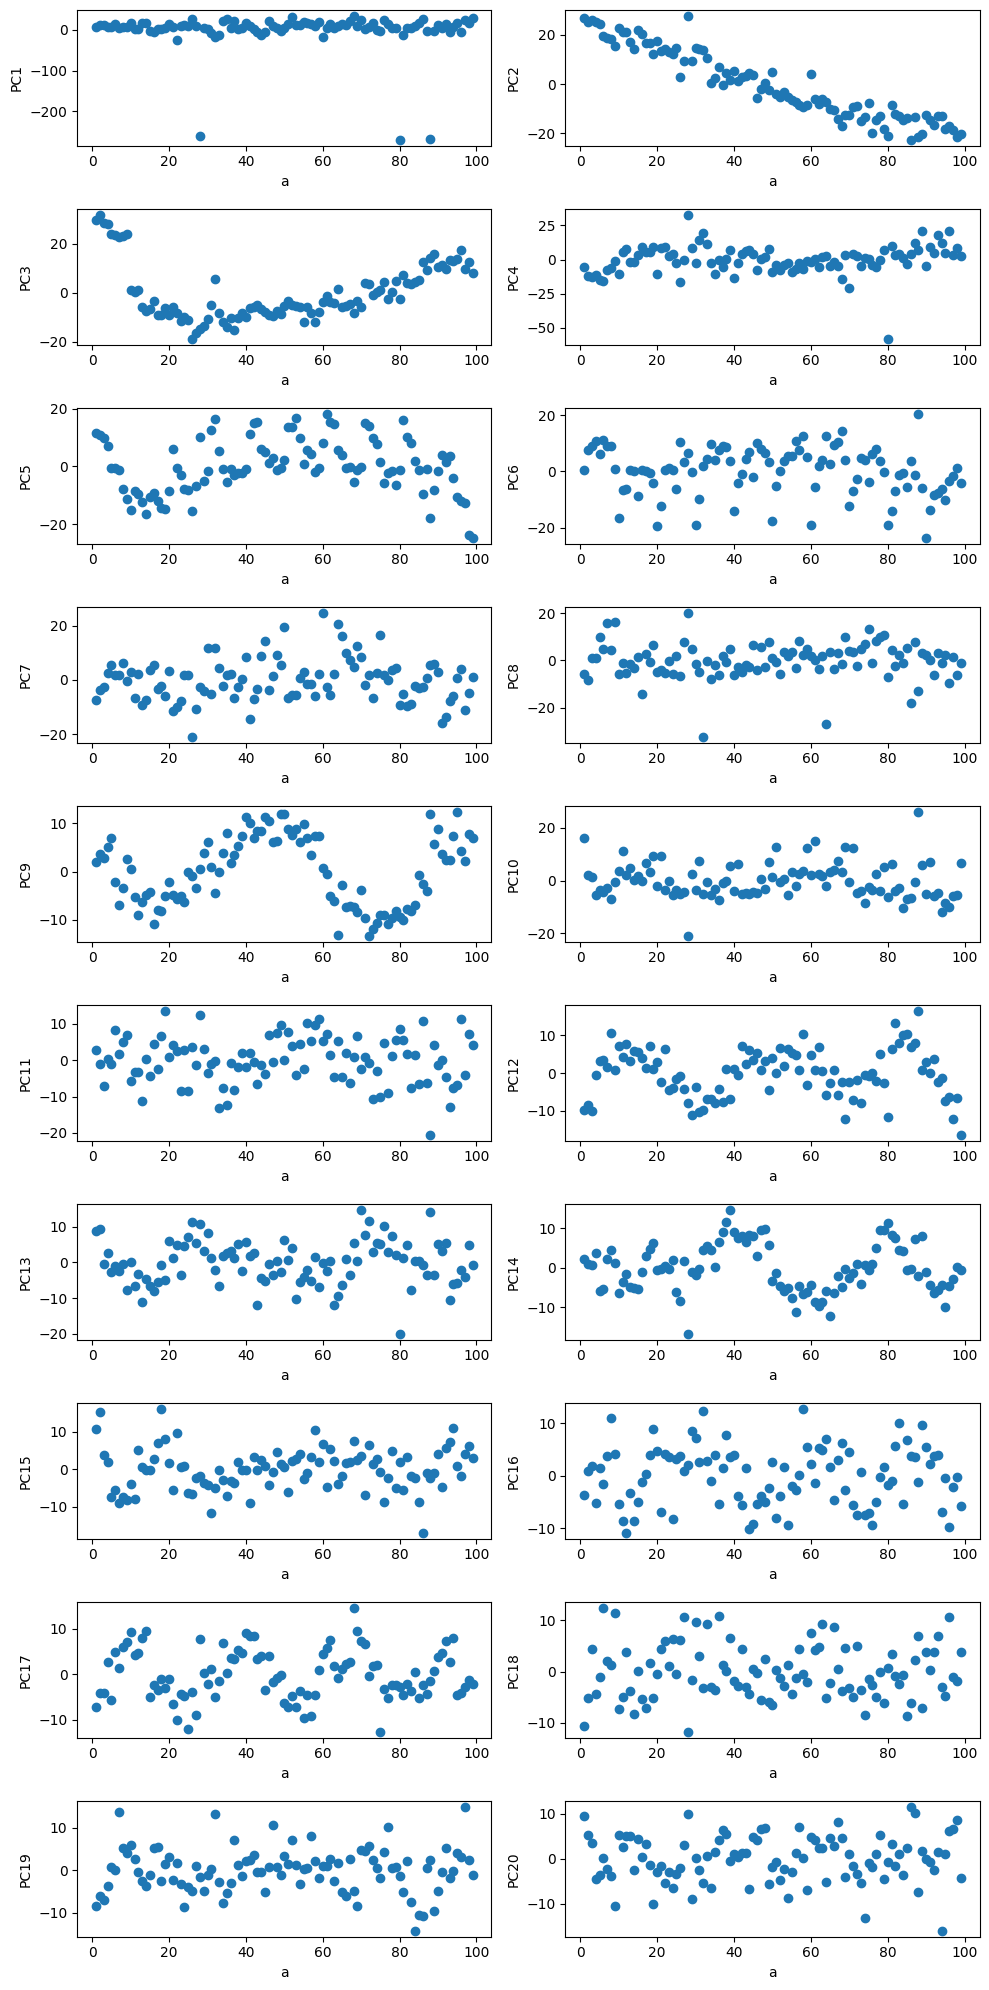

In [100]:
# Plot principal components

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
axs = axs.ravel()
for i in range(20):
    x = a[rng]
    # x = np.log(a[rng] / 50)
    axs[i].scatter(x, (tf[:, i][rng]))
    axs[i].set_xlabel('a')
    axs[i].set_ylabel(f'PC{i+1}')
plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00, 850.94it/s]

linear r2 score 0.004220411098106669 0
log r2 score 0.004386137677752422 0
log is better


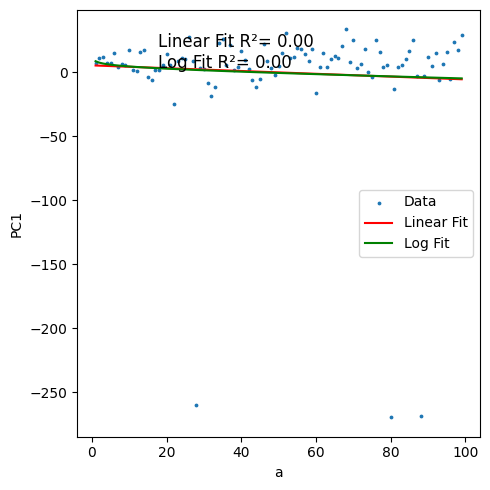

100%|██████████| 1/1 [00:00<00:00, 854.24it/s]


linear r2 score 0.9087039674274978 0
log r2 score 0.9146105076408504 0
log is better


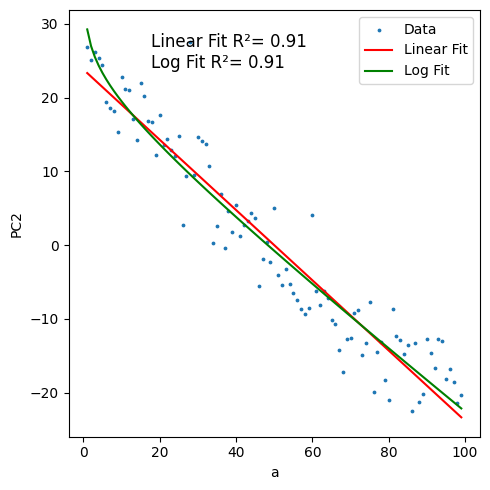

100%|██████████| 1/1 [00:00<00:00, 964.65it/s]


linear r2 score 0.007632568311789822 0
log r2 score 0.7742704694711033 0
log is better


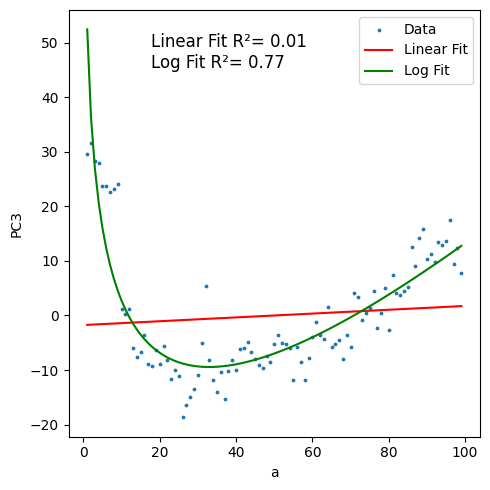

100%|██████████| 1/1 [00:00<00:00, 910.62it/s]


linear r2 score 0.02282384269579818 0
log r2 score 0.042512431257719197 0
log is better


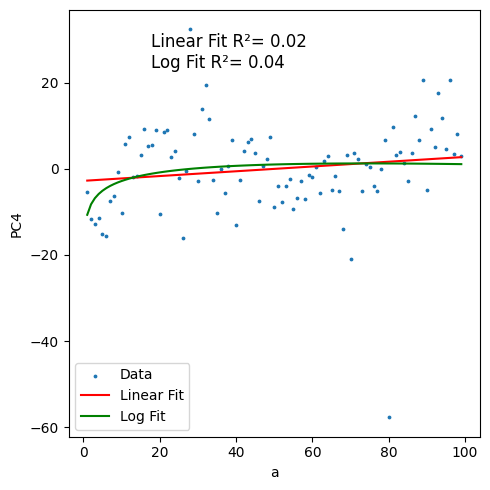

100%|██████████| 1/1 [00:00<00:00, 912.80it/s]


linear r2 score 0.001107320256618749 0
log r2 score 0.0034472307523700785 0
log is better


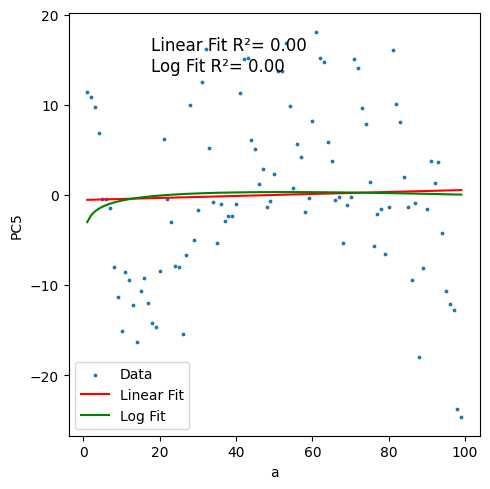

In [106]:
# Fits a given component to a linear/log fit.

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)

component = 6
for component in range(0, 5):
    y = tf[:, component]

    def fit(period, is_log):
        if is_log:
            t = [a, np.log(a)]
        else:
            t = [a]

        X = np.stack(t, axis = 1)

        lr = LinearRegression()
        
        lr.fit(X, y)
        r2 = lr.score(X, y)

        y_pred = lr.predict(X)

        return r2, lr, y_pred, period

    def best_fit(periods, is_log):
        results = [fit(period, is_log) for period in tqdm(periods)]
        best = max(results, key=lambda x: x[0])
        return best

    best_linear = best_fit([0], False)
    best_log = best_fit([0], True)

    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs = axs

    axs.scatter(a, y, s=3)
    axs.plot(a, best_linear[2], color='red')
    axs.plot(a, best_log[2], color='green')
    axs.set_xlabel('a')
    axs.set_ylabel(f'PC{component+1}')
    plt.tight_layout()
    print("linear r2 score", best_linear[0], best_linear[3])
    print("log r2 score", best_log[0], best_log[3])
    print("log is better" if best_log[0] > best_linear[0] else "linear is better")
    plt.legend(['Data', 'Linear Fit', 'Log Fit'])
    plt.text(0.2, 0.9, f'Linear Fit R²= {best_linear[0]:.2f}\nLog Fit R²= {best_log[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=axs.transAxes, fontsize=12)

    plt.show()

# LOG is better: PC3




100%|██████████| 300/300 [00:00<00:00, 1058.14it/s]


linear r2 score 0.06064040305499918 54.05086734523033
log r2 score 0.06063532898066715 1.1235166816909297
linear is better


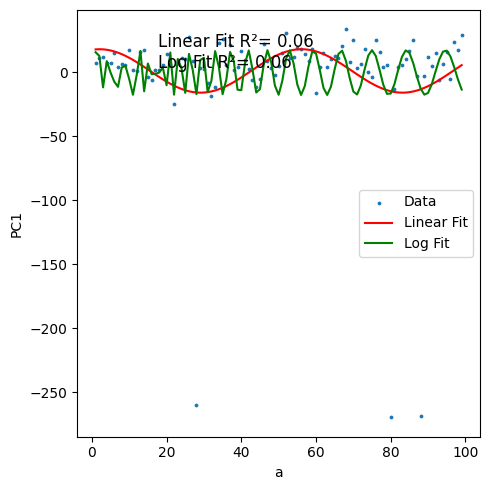

100%|██████████| 300/300 [00:00<00:00, 1077.15it/s]


linear r2 score 0.9273895089405371 255.18398551895493
log r2 score 0.467448311566932 10.0
linear is better


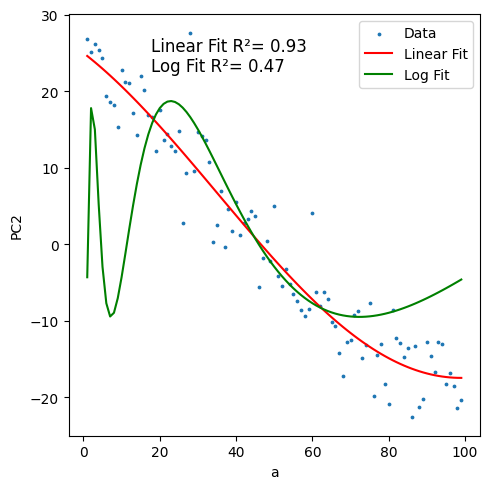

100%|██████████| 300/300 [00:00<00:00, 1052.40it/s]


linear r2 score 0.6456100750115394 300.0000000000001
log r2 score 0.25944008914901284 10.0
linear is better


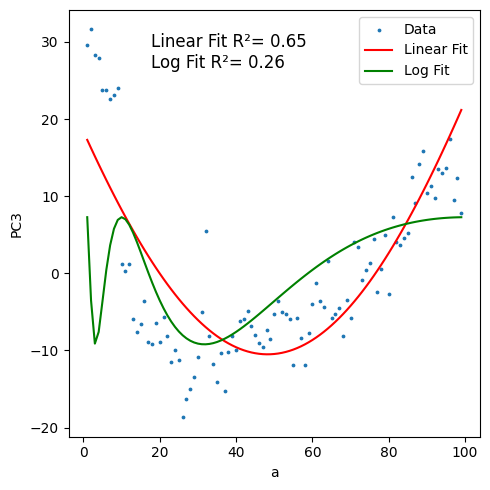

100%|██████████| 300/300 [00:00<00:00, 1040.99it/s]


linear r2 score 0.1884653340823108 65.86968420243626
log r2 score 0.11053811911729328 1.4373299660259082
linear is better


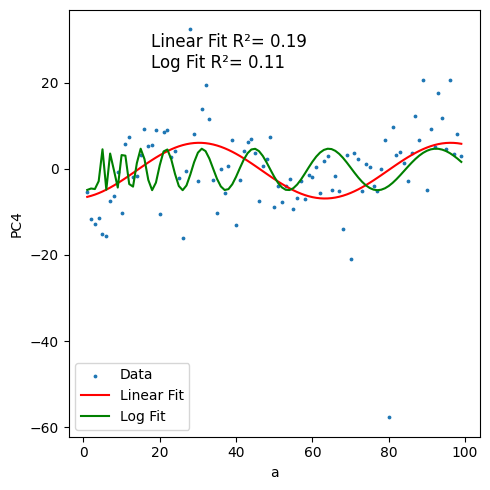

100%|██████████| 300/300 [00:00<00:00, 1044.73it/s]


linear r2 score 0.3429858329580221 80.75529496798227
log r2 score 0.3301378341355188 10.0
linear is better


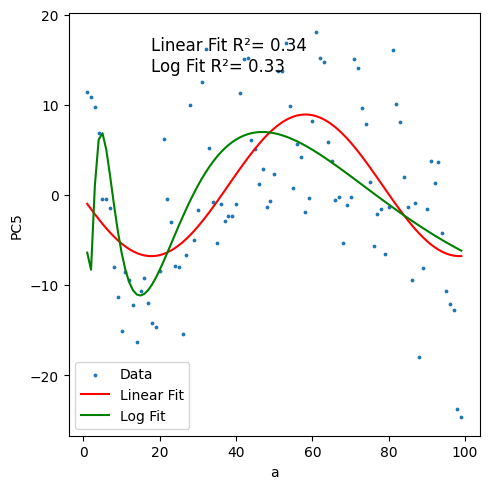

100%|██████████| 300/300 [00:00<00:00, 1034.85it/s]


linear r2 score 0.10979576631392574 65.47614002176431
log r2 score 0.17284409037427906 1.1497637569508672
log is better


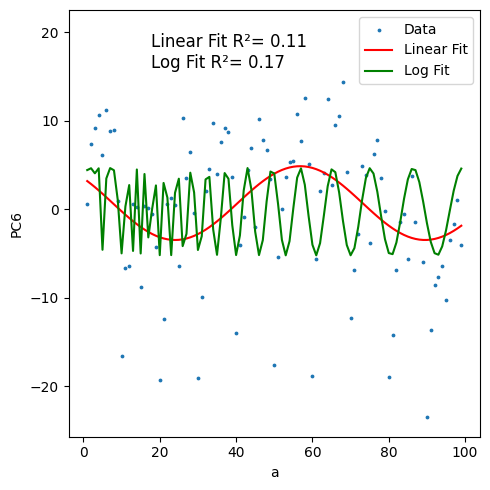

100%|██████████| 300/300 [00:00<00:00, 1050.77it/s]


linear r2 score 0.13915586564325455 74.70305189756448
log r2 score 0.1177372986388393 9.117665221171446
linear is better


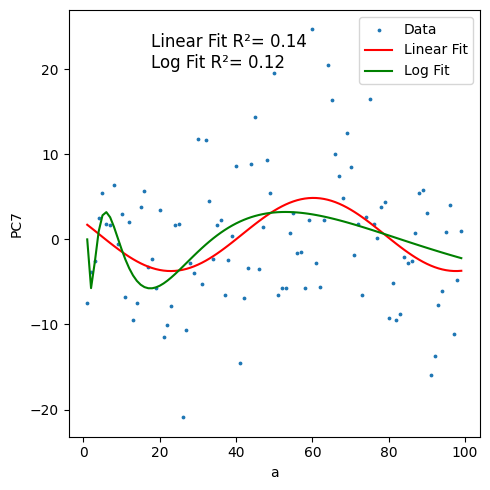

100%|██████████| 300/300 [00:00<00:00, 1098.24it/s]


linear r2 score 0.048116500634353354 70.7808431718822
log r2 score 0.1384561555417526 1.4153714151170234
log is better


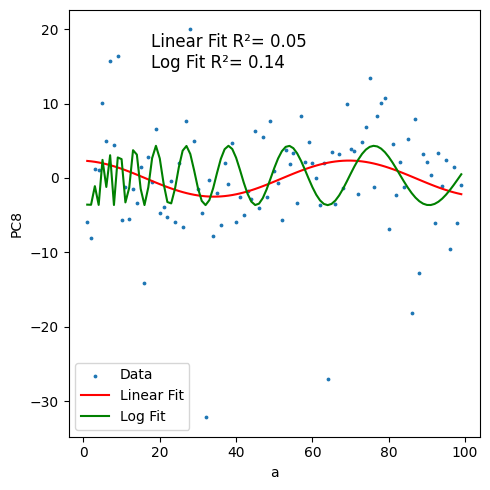

100%|██████████| 300/300 [00:00<00:00, 1109.86it/s]


linear r2 score 0.7588261838482344 56.02962846550877
log r2 score 0.35903329411823504 2.246219591340422
linear is better


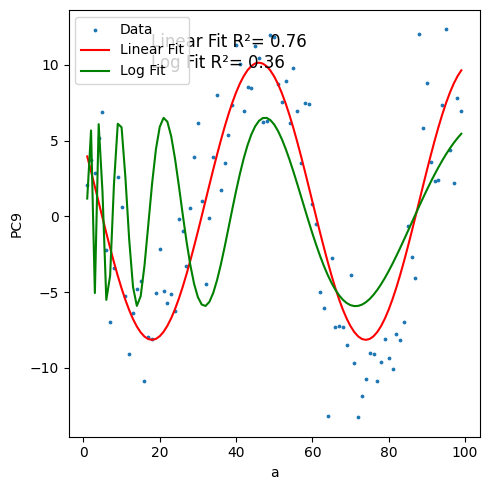

100%|██████████| 300/300 [00:00<00:00, 1107.79it/s]


linear r2 score 0.10446555242798272 58.080830524544346
log r2 score 0.13873761690345054 4.032018153092974
log is better


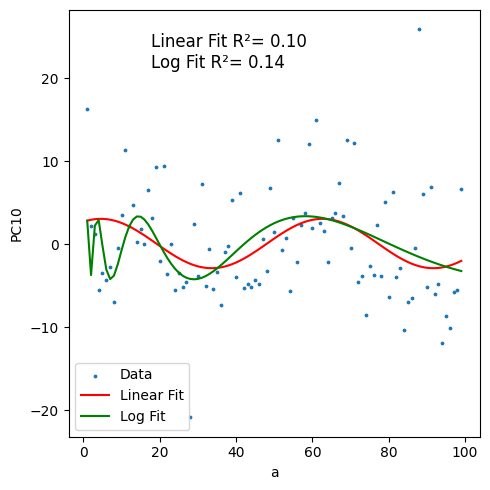

In [105]:
# Fits a given sin/cos component to a sine wave.

import matplotlib.pyplot as plt
#rng = slice(0, 105)
rng = slice(None, None)

component = 6
for component in range(0, 10):
    y = tf[:, component]

    def fit(period, is_log):
        if is_log:
            t = np.log(a)
            sina = np.sin(t / np.log(period) * 2*np.pi)
            cosa = np.cos(t / np.log(period) * 2*np.pi)
        else:
            t = a/period
            sina = np.sin(t * 2*np.pi)
            cosa = np.cos(t * 2*np.pi)

        X = np.stack([sina, cosa], axis = 1)

        lr = LinearRegression()
        
        lr.fit(X, y)
        r2 = lr.score(X, y)

        y_pred = lr.predict(X)

        return r2, lr, y_pred, period

    def best_fit(periods, is_log):
        results = [fit(period, is_log) for period in tqdm(periods)]
        best = max(results, key=lambda x: x[0])
        return best

    best_linear = best_fit(np.logspace(np.log10(50), np.log10(300), 300), False)
    best_log = best_fit(np.logspace(np.log10(1.001), np.log10(10), 300), True)

    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    axs = axs

    axs.scatter(a, y, s=3)
    axs.plot(a, best_linear[2], color='red')
    axs.plot(a, best_log[2], color='green')
    axs.set_xlabel('a')
    axs.set_ylabel(f'PC{component+1}')
    plt.tight_layout()
    print("linear r2 score", best_linear[0], best_linear[3])
    print("log r2 score", best_log[0], best_log[3])
    print("log is better" if best_log[0] > best_linear[0] else "linear is better")
    plt.legend(['Data', 'Linear Fit', 'Log Fit'])
    plt.text(0.2, 0.9, f'Linear Fit R²= {best_linear[0]:.2f}\nLog Fit R²= {best_log[0]:.2f}', horizontalalignment='left', verticalalignment='center', transform=axs.transAxes, fontsize=12)

    plt.show()

# LOG is better: PC3




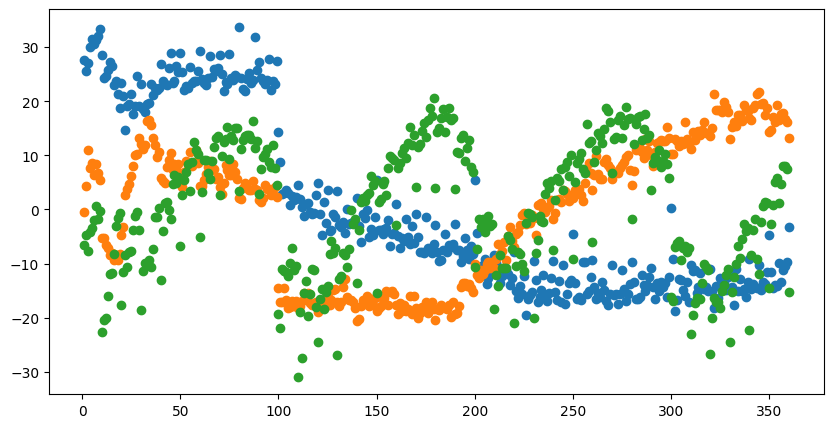

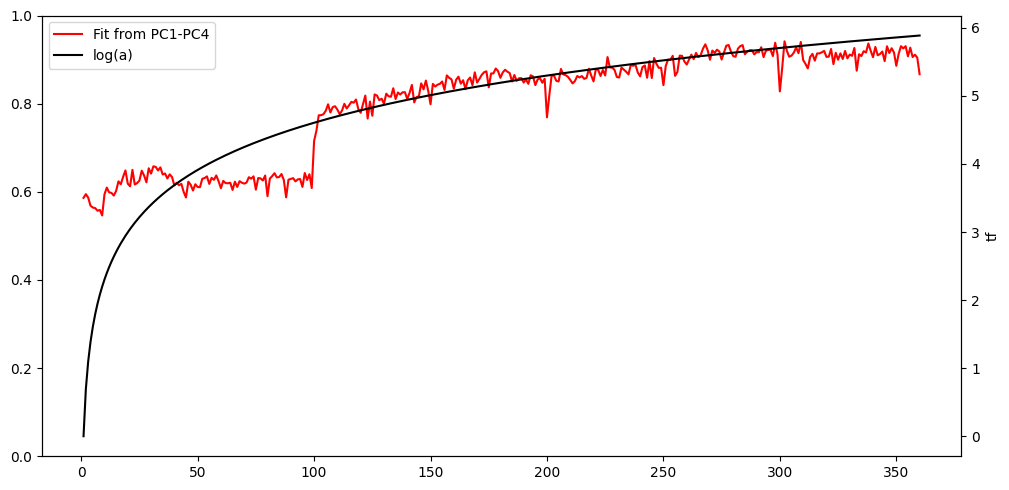

r2 score of lr: 0.7652744291569786
coefficients of lr: [-0.04727586  0.00084248  0.00170399 -0.          0.         -0.01123321
  0.         -0.          0.          0.        ]


In [11]:
# Fit PC to logarithm.
# I played with components and alpha and it never plausibly recovered a fit.
components = slice(0, 10)
from sklearn.linear_model import Lasso
lr = Lasso(alpha=1)
# lr = LinearRegression()

lr.fit(tf[:, components], np.log(a))
plt.figure(figsize=(10, 5))
plt.scatter(a, tf[:, 0], label='PC1')
plt.scatter(a, tf[:, 1], label='PC2')
plt.scatter(a, tf[:, 2], label='PC3')
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
# ax1.scatter(a, tf[:, 0], label='PC1')
# ax1.scatter(a, tf[:, 1], label='PC2')
ax2.plot(a, lr.predict(tf[:, components]), color='red', label='Fit from PC1-PC4')
ax2.plot(a, np.log(a), color='black', label='log(a)')
plt.tight_layout()
plt.xlabel('a')
plt.ylabel('tf')
plt.legend()
plt.show()
print("r2 score of lr:", lr.score(tf[:, components], np.log(a)))
print("coefficients of lr:", lr.coef_)



In [12]:
def check_tokenization(mina, maxa):
    "Check range of values is safe for the one-token assumption. More precise than the original paper."
    for a in range(mina, maxa+1):
        for b in range(mina, maxa+1):
            if OPERATION == "addition":
                text = f"{a}+{b}="
            else:
                text = f"{a}*{b}="
            tokens = model.tokenizer.tokenize(text)
            assert len(tokens) == 4, tokens
check_tokenization(0, 520)